In [1]:
# импорт нужных бмблиотек для ДЗ 2, 3, 4.
from __future__ import print_function
import psycopg2
import getpass
import pandas as pd
import datetime
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML, Document
import matplotlib.pyplot as plt
import numpy as np

# HW2

In [2]:
# коннектимся к базе данных
conn=psycopg2.connect(user='postgres',
                      database='postgres',
                      host='localhost',
                      port='5432',
                      password=getpass.getpass('Insert password: ')
                        )

Insert password: ········


In [3]:
# запрос для необходимых данных. Т.к в данных по облигациям с фиксированным купоном встречаются разные купонные выплаты,
# сделано предположение использовать максимальный купонный платеж из имеющихся по облигации
query = """SELECT *
            FROM (SELECT MAX("CPN") AS "CPN", "ISIN", max("BUYBACKDATE") AS "BUYBACKDATE",
                  max("BUYBACKPRICE") AS "BUYBACKPRICE"
                  FROM bonds.quotes  
                  GROUP BY "ISIN") AS cpn
            INNER JOIN(SELECT "ISINCode", "FaceValue", "HaveOffer", "AmortisedMty", 
                       "CouponPerYear", "NumCoupons", "EndMtyDate", "CouponType", "IssuerName"
                       FROM bonds.bond_description 
                       WHERE "Status"!='Погашен' AND "CouponType" != 'Переменный' ) AS bonds
            ON cpn."ISIN" = bonds."ISINCode" """

In [4]:
# забираем нужные данные из базы
data = pd.read_sql_query(query, conn)
data = pd.DataFrame(data)
data.head()

,CPN,ISIN,BUYBACKDATE,BUYBACKPRICE,ISINCode,FaceValue,HaveOffer,AmortisedMty,CouponPerYear,NumCoupons,EndMtyDate,CouponType,IssuerName
0,NaN,RU000A0JNN80,None,0.0,RU000A0JNN80,1000.0,False,False,2,6,2009-09-17,Постоянный,МГ Групп
1,40.11,RU000A0JNYN1,None,NaN,RU000A0JNYN1,1000.0,False,False,2,31,2022-06-11,Фиксированный,Москва Правительство
2,40.11,RU000A0JNYP6,None,0.0,RU000A0JNYP6,1000.0,True,False,2,21,2017-06-14,Фиксированный,Москва Правительство
3,40.33,RU000A0JPZ50,None,NaN,RU000A0JPZ50,1000.0,True,False,2,16,2016-09-22,Фиксированный,Москва Правительство
4,40.33,RU000A0JPZ68,None,NaN,RU000A0JPZ68,1000.0,False,False,2,22,2019-09-29,Фиксированный,Москва Правительство


In [5]:
# убираем ISINCode, т.к. он требовался только для соединения таблиц, далее не нужен.
data = data.drop(['ISINCode'], axis=1)

data.head(5)

,CPN,ISIN,BUYBACKDATE,BUYBACKPRICE,FaceValue,HaveOffer,AmortisedMty,CouponPerYear,NumCoupons,EndMtyDate,CouponType,IssuerName
0,NaN,RU000A0JNN80,None,0.0,1000.0,False,False,2,6,2009-09-17,Постоянный,МГ Групп
1,40.11,RU000A0JNYN1,None,NaN,1000.0,False,False,2,31,2022-06-11,Фиксированный,Москва Правительство
2,40.11,RU000A0JNYP6,None,0.0,1000.0,True,False,2,21,2017-06-14,Фиксированный,Москва Правительство
3,40.33,RU000A0JPZ50,None,NaN,1000.0,True,False,2,16,2016-09-22,Фиксированный,Москва Правительство
4,40.33,RU000A0JPZ68,None,NaN,1000.0,False,False,2,22,2019-09-29,Фиксированный,Москва Правительство


In [6]:
def get_date(date_entry):
    # метод для получения даты из строки
    # формат YYYY-MM-DD
    year, month, day = map(int, date_entry.split('-'))
    return datetime.date(year, month, day)

In [7]:
def build_matrix_dict(issuer_name, terminal_date):
    # составим список дат платежей для каждой облигации
    
    # получим нужные облигации
    terminal_date = get_date(terminal_date)
    obligations = data[data['IssuerName'] == issuer_name]
    
    
    matrix = dict()
    
    # для каждой облигации составляем список дат
    for index, obligation in obligations.iterrows():
        matrix[obligation['ISIN']] = []
        
        # считаем периодичность в зависимости от количества выплат в течение года (в дняхх)
        periodicity = 365 // obligation['CouponPerYear']
        
        # учитываем дату отсчета
        payment_date = None
        if obligation['BUYBACKDATE'] is not None:
            payment_date = obligation['BUYBACKDATE']
        else:
            payment_date = obligation['EndMtyDate']
            
        for i in range(obligation['NumCoupons']):
            
            # даты больше введеной пропускаем
            if payment_date > terminal_date:
                pass
            else:
                matrix[obligation['ISIN']].append(payment_date)
            
            # считаем следующую дату выплаты
            payment_date = payment_date - datetime.timedelta(days=periodicity)
    return matrix    
    

In [8]:
def build_matrix_df(matrix_dict):
    # строим датафрейм для матрицы дат
    
    # сначала получим список всех дат всех облигаций, они будут колонками
    date_set=set()
    for isin in matrix_dict:
        date_set.update(matrix_dict[isin])
    date_set = list(date_set)
    date_set.sort()
    
    # строим дата фрейм, где строки - облигации, колонки - даты
    I = pd.Index(matrix_dict.keys(), name="rows")
    C = pd.Index(date_set, name="cols")
    df = pd.DataFrame(data=0.0, index = I, columns = C)
    
    # заполняем дата фрейм
    for isin in matrix_dict:
        
        # для каждой облигации берем список дат
        datelist = matrix_dict[isin]
        
        # и заполняем его верным значением в зависимости от даты
        obligation = data[data['ISIN'] == isin].iloc[0]
        cpn = obligation['CPN']
        face_value = obligation['FaceValue']
        
        # определяем верную дату
        terminal_date = None
        if obligation['BUYBACKDATE'] is not None:
            terminal_date = obligation['BUYBACKDATE']
        else:
            terminal_date = obligation['EndMtyDate']
            
        for the_date in datelist:
        # и наконец заполняем значение выплаты
            if the_date == terminal_date:
                df.at[isin, the_date] = cpn + face_value
            else:
                df.at[isin, the_date] = cpn
    return df
    df

In [9]:
issuer_name = input('Введите IssuerName')
term_date = input('Введите дату в формате YYYY-MM-DD')
matrix = build_matrix_dict(issuer_name, term_date)
schedule_matrix = build_matrix_df(matrix)
schedule_matrix

Введите IssuerNameБанк ВТБ
Введите дату в формате YYYY-MM-DD2018-05-21


cols,2013-04-23,2013-05-21,2013-07-23,2013-08-20,2013-10-22,2013-11-19,2014-01-21,2014-02-18,2014-04-22,2014-05-20,...,2015-01-20,2015-02-17,2015-04-21,2015-05-19,2015-07-21,2015-08-18,2015-10-20,2015-11-17,2016-01-19,2016-02-16
rows,,,,,,,,,,,,,,,,,,,,,
RU000A0JTK20,20.32,0.0,20.32,0.0,20.32,0.0,20.32,0.0,20.32,0.0,...,20.32,0.0,20.32,0.0,20.32,0.0,20.32,0.0,1020.32,0.0
RU000A0JTN01,0.00,19.7,0.00,19.7,0.00,19.7,0.00,19.7,0.00,19.7,...,0.00,19.7,0.00,19.7,0.00,19.7,0.00,19.7,0.00,1019.7


# HW3

In [10]:
# попытка составить датафрейм с информацией об амортизации, поскольку этого не было учтено в ДЗ2
def build_amortised_dict(issuer_name):
    
    # получим нужные облигации
    obligations = data[data['IssuerName'] == issuer_name]
    
    
    matrix = dict() # ключ - код облигации, значение - является ли она амортизационной
    for index, obligation in obligations.iterrows():
        matrix[obligation['ISIN']] = obligation['AmortisedMty']
    return matrix

In [11]:
# транспонируем матрицу платежей, поскольку суммировать по столбцам проще. Посчитаем амортизацинноые суммы (по строкам)
# затем удалим ненужные колонки и транспонируем обратно в изначальный формат
def build_amortised_sums(issuer_name):
    who_amortised_dict = build_amortised_dict(issuer_name)
    amortised_cols = []
    not_amortised_cols = []
    for obligation_isin in who_amortised_dict:
        if who_amortised_dict[obligation_isin]:
            amortised_cols.append(obligation_isin)
        else:
            not_amortised_cols.append(obligation_isin)
    transposed_schedule_matrix = schedule_matrix.T
    transposed_schedule_matrix['amortised_sum'] = transposed_schedule_matrix[amortised_cols].sum(axis=1)
    transposed_schedule_matrix['not_amortised_sum'] = transposed_schedule_matrix[not_amortised_cols].sum(axis=1)
    transposed_schedule_matrix = transposed_schedule_matrix.drop(amortised_cols, axis=1)
    transposed_schedule_matrix = transposed_schedule_matrix.drop(not_amortised_cols, axis=1)
    return transposed_schedule_matrix.T    

In [12]:
# само суммирование выплат по каждому типу облигаций
sums_by_date_df = build_amortised_sums(issuer_name)
sums_by_date_df.head(10)

cols,2013-04-23,2013-05-21,2013-07-23,2013-08-20,2013-10-22,2013-11-19,2014-01-21,2014-02-18,2014-04-22,2014-05-20,...,2015-01-20,2015-02-17,2015-04-21,2015-05-19,2015-07-21,2015-08-18,2015-10-20,2015-11-17,2016-01-19,2016-02-16
rows,,,,,,,,,,,,,,,,,,,,,
amortised_sum,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,...,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0
not_amortised_sum,20.32,19.7,20.32,19.7,20.32,19.7,20.32,19.7,20.32,19.7,...,20.32,19.7,20.32,19.7,20.32,19.7,20.32,19.7,1020.32,1019.7


In [13]:
# построим график платежей
def build_fig(sums_matrix):
    dates_graph = sums_matrix.columns
    amort = sums_matrix.iloc[0]
    not_amort = sums_matrix.iloc[1]
    plt.subplots(figsize=(30,15))
    p1 = plt.bar(dates_graph, amort, width = 10, color="#ff0000")
    p2 = plt.bar(dates_graph, not_amort, width = 10, bottom = amort, color="#1100ff")

    plt.xlabel('Payment days')
    plt.ylabel('Number of payments')
    plt.xticks(rotation=90)
    plt.title('Payments of '+ issuer_name)
    b1 = sums_matrix[sums_matrix.index.get_level_values('rows') == 'amortised_sum'].index[0]
    b2 = sums_matrix[sums_matrix.index.get_level_values('rows') == 'not_amortised_sum'].index[0]
    plt.legend((p1[0], p2[0]), (str(b1), str(b2)))

    payments_graph = plt.show(p1, p2)
    return payments_graph

/Users/danis/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


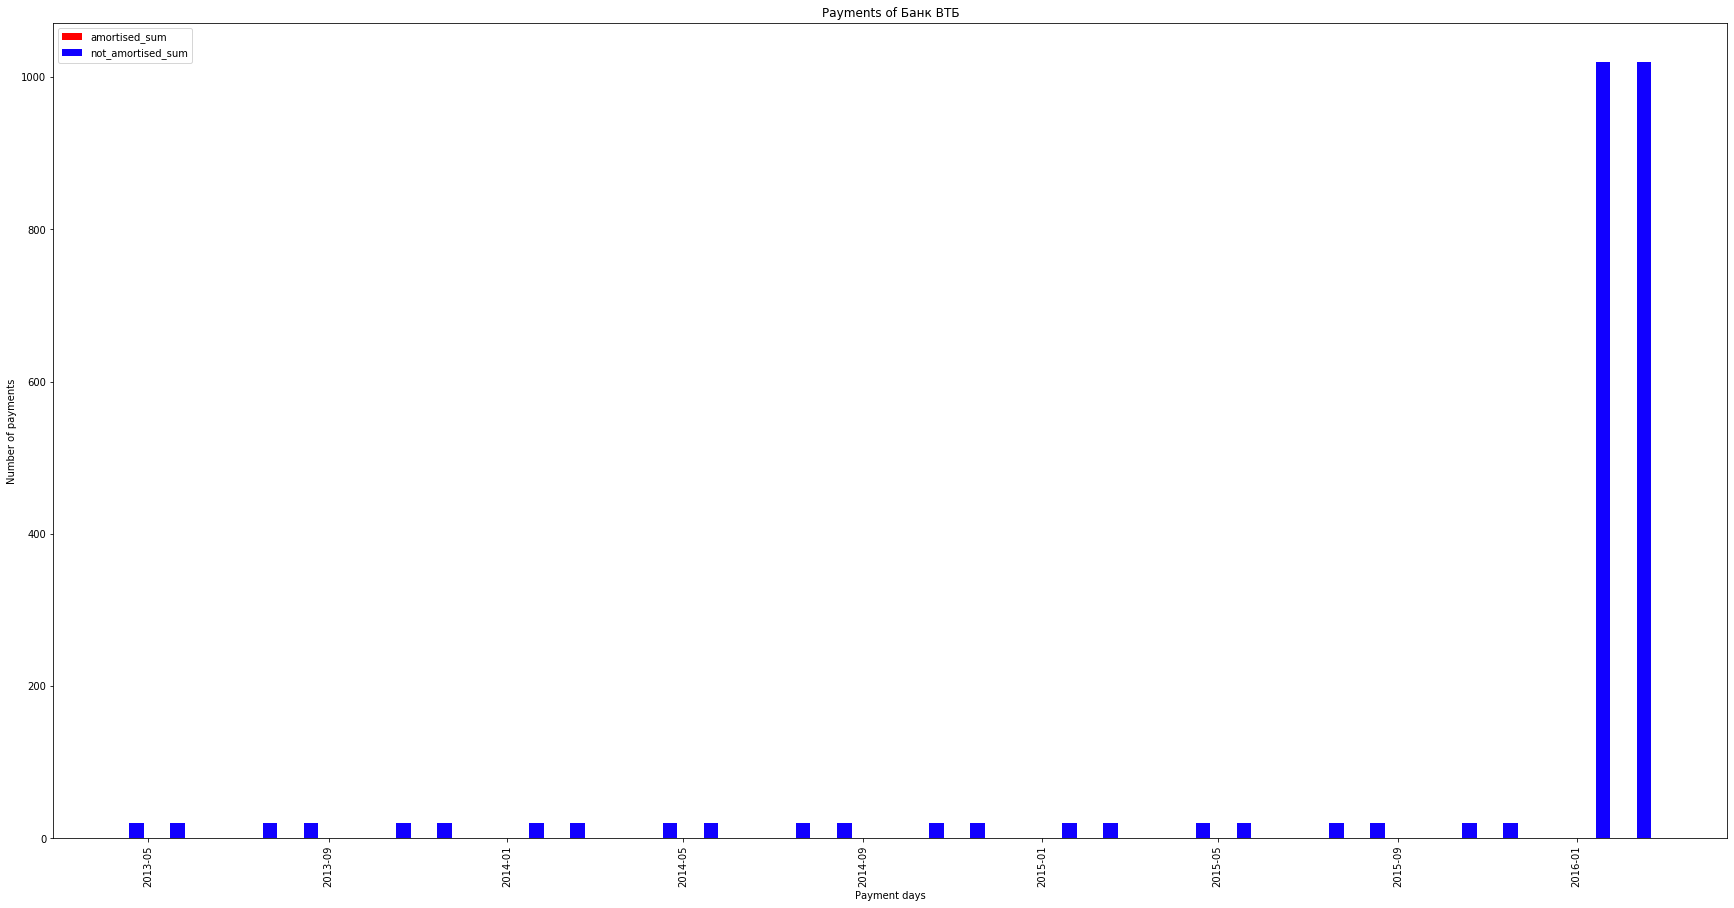

In [14]:
build_fig(sums_by_date_df)

# HW4

In [15]:
# спросим у пользователя имя файла (функция). Можно не выбирать имя, тогда будет назначено автоматически
def ask_file_name(export_object):
    base = 'Введите имя файла для сохранения (с указанием формата) '
    if export_object == '1':
        base += 'таблицы'
    if export_object == '2':
        base += 'графика'
    if export_object == '3':
        base += 'отчета'
    base += ' (Можно оставить пустым, будет выбрано имя по умолчанию)'
    name = input(base)
    if name == '' or name is None:
        return filename_dict[export_object]
    return name

In [16]:
# спросим у пользователя директорию (ее указать обязательно)
def ask_directory():
    directory = None
    while directory is None or directory == '':
        directory = input('Введите путь до директории сохранения')
    return directory

In [17]:
my_directory = ask_directory()
#my_directory = '/Users/danis/anaconda3/pkgs/conda-4.7.10-py37_0/info/test/tests/data/tar_traversal/dirsym/tmp'

# стандартные имена файлов будем хранить в отдельном словаре
filename_dict = {'1': 'my_table.csv', '2': 'my_graph.png', '3': 'my_report.pdf'}

Введите путь до директории сохранения/Users/danis/anaconda3/pkgs/conda-4.7.10-py37_0/info/test/tests/data/tar_traversal/dirsym/tmp


In [18]:
# сохраняем таблицу в формате csv
def save_table(table_as_df, filename):
    table_as_df.to_csv(filename, sep=';', encoding='utf-8')

In [19]:
# формируем отчет в pdf
def save_pdf(filename, image_path):
    import os

    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template("myreport.html") 
    template_vars = {"title": "Отчет составлен Слукиным Данисом",
                    "INTRO": "Данный отчет содержит информацию по облигациям с фиксированным купоном компании " + issuer_name, 
                     "TABLE_DESC": "В таблице представлена матрица платежей по облигациям с фиксированным купоном компании " + issuer_name, 
                     "TABLE": schedule_matrix.to_html(), 
                     "IMAGE_DESC": "На столбчатой диаграмме изображено распределение купонных выплат компании " + issuer_name, 
                     "IMAGE": os.path.abspath(image_path)
                    }
    
    html_out = template.render(template_vars, presentational_hints=True)
    HTML(string=html_out).write_pdf(filename, presentational_hints=True)

In [20]:
# сохраняем график в картинку
def save_figure(sums_matrix, filename):
    dates_graph = sums_matrix.columns
    amort = sums_matrix.iloc[0]
    not_amort = sums_matrix.iloc[1]
    plt.subplots(figsize=(18,10))
    p1 = plt.bar(dates_graph, amort, width = 5, color="#ff0000")
    p2 = plt.bar(dates_graph, not_amort, width = 5, bottom = amort, color="#1100ff")

    plt.xlabel('Payment days')
    plt.ylabel('Number of payments')
    plt.xticks(rotation=90)
    plt.title('Payments of '+ issuer_name)
    b1 = sums_matrix[sums_matrix.index.get_level_values('rows') == 'amortised_sum'].index[0]
    b2 = sums_matrix[sums_matrix.index.get_level_values('rows') == 'not_amortised_sum'].index[0]
    plt.legend((p1[0], p2[0]), (str(b1), str(b2)))

    plt.savefig(filename)

Введите номера через пробел объектов, которые нужно сохранить: 1. Таблица 2. График 3. Отчет1 2
Введите имя файла для сохранения (с указанием формата) таблицы (Можно оставить пустым, будет выбрано имя по умолчанию)Таблица платежей ВТБ.csv
Введите имя файла для сохранения (с указанием формата) графика (Можно оставить пустым, будет выбрано имя по умолчанию)


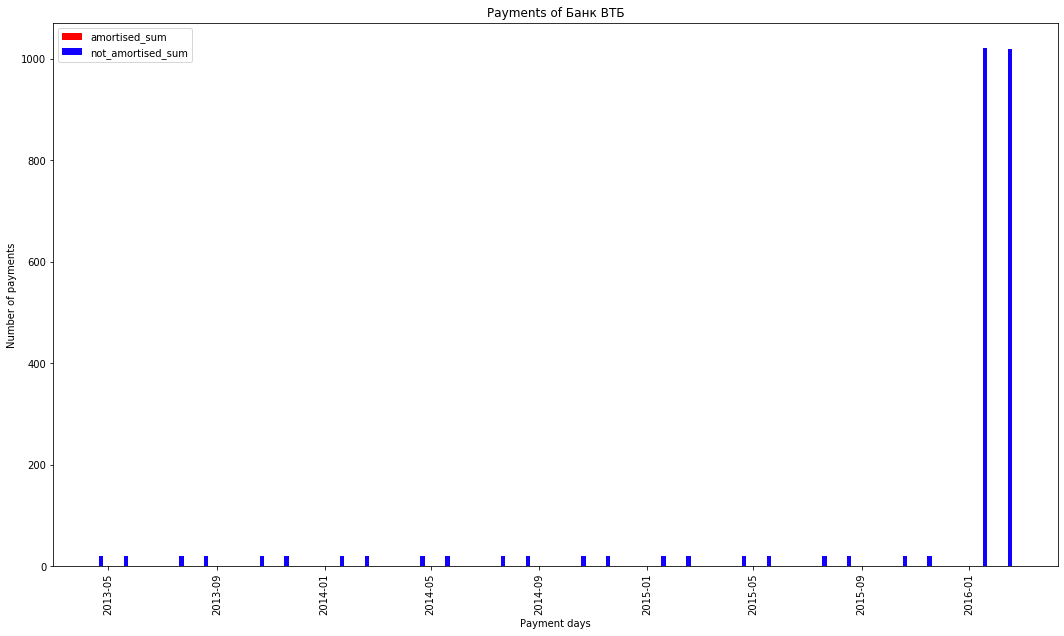

In [21]:
# управление опцией для выбора объекта экспортирования осуществляется отсюда
what_to_export = input('Введите номера через пробел объектов, которые нужно сохранить: 1. Таблица 2. График 3. Отчет')
export_objects = what_to_export.split()
image_path = ''
for export_object in export_objects:
    filename = ask_file_name(export_object)
    path_to_save = my_directory + '/' + filename
    if export_object == '1':
        save_table(schedule_matrix, path_to_save)
    if export_object == '2':
        save_figure(sums_by_date_df, path_to_save)
        image_path = path_to_save
    if export_object == '3':
        save_pdf(path_to_save, image_path)

# Готово! В качестве примера использовалась опция сохранить на выбор только таблицу и график. Для таблицы задавалось имя,
# а для графика не вводилось и использовалось имя по умолчанию "my_graph.png"
